### SQL + Python Project

In [1]:
import pandas as pd
import matplotlib .pyplot as plt
import seaborn as sns
import mysql.connector
import pymysql
import os
import plotly.express as px
import numpy as np

In [2]:
# Set pandas to display all columns
pd.set_option('display.max_columns', None)
# Set pandas to display all columns
pd.set_option('display.max_rows', None)

In [3]:
# Connect to the MySQL database
conn = pymysql.connect(
    host='127.0.0.1',
    user='root',
    password='Shubham@123',
    database='ecommerce',
    cursorclass=pymysql.cursors.DictCursor
)
cur = conn.cursor()

### 1: List all unique cities where customers are located.

In [19]:
query = """ select distinct customer_city from customers """

cur.execute(query)

data = cur.fetchall()
data
df = pd.DataFrame(data)

display(df.head(),df.count())

,customer_city
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


customer_city    4119
dtype: int64

### 2: Count the number of orders placed in 2017.

In [21]:
query = """ select year(order_purchase_timestamp),count(order_id) 'order_count' from orders 
group by 1
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data)
df

,year(order_purchase_timestamp),order_count
0,2017,45101
1,2018,54011
2,2016,329


### 3: Find the total sales per category

In [6]:
query = """ select p.product_category,count(oi.order_id) 'Total_order',
round(sum(pe.payment_value),0) 'Sales_Price'
 from ecommerce.products p 
left join ecommerce.order_items oi on oi.product_id = p.product_id
left join ecommerce.payments pe on pe.order_id = oi.order_id
GROUP BY 1
"""

cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data)
df.sort_values(by='Sales_Price', ascending=False).head()


,product_category,Total_order,Sales_Price
19,bed table bath,11823,1712554.0
16,HEALTH BEAUTY,9975,1657373.0
6,computer accessories,8082,1585330.0
15,Furniture Decoration,8744,1430176.0
4,Watches present,6201,1429217.0


### 4: Calculate the percentage of orders that were paid in installments.

In [7]:
 query = """ select 
 sum(case when payment_installments >= 1 then 1 ELSE 0 END)/count(*)*100 
 as '%_of_installment_greater_than_1' 
 from ecommerce.payments
"""

cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data)
df


,%_of_installment_greater_than_1
0,99.9981


### 5. Count the number of customers from each state.

D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


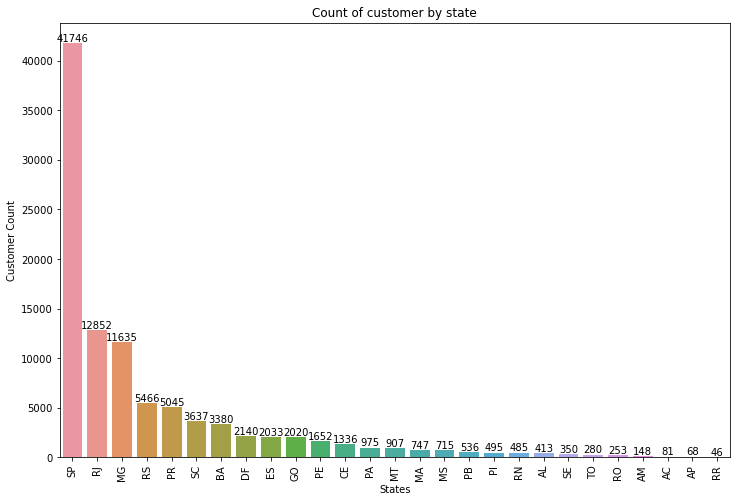

In [24]:
 query = """  select customer_state,count(customer_id) 'Customer_count' 
 from ecommerce.customers
 GROUP BY 1;
"""

cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data)
df

df = df.sort_values(by = 'Customer_count', ascending= False)

# Adjust the figure size
plt.figure(figsize=(12, 8))

# Create the bar plot
ax = sns.barplot(df['customer_state'], df['Customer_count'], data=df)
plt.xlabel('States')
plt.ylabel('Customer Count')
plt.title('Count of customer by state')
# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

ax.bar_label(ax.containers[0])
# Show the plot
plt.show()


-  MG - Minas Gerais
-  RS - Rio Grande do Sul
-  PR - Paraná
-  SC - Santa Catarina
-  BA - Bahia
-  DF - Distrito Federal
-  ES - Espírito Santo
-  PE - Pernambuco
-  CE - Ceará
-  MA - Maranhão
-  MS - Mato Grosso do Sul
-  PB - Paraíba
-  PI - Piauí
-  RN - Rio Grande do Norte
-  RO - Rondônia
-  AM - Amazonas
-  AC - Acre
-  AP - Amapá
-  RR - Roraima
-  GO - Goiás 

###  6: Calculate the number of orders per month in 2018.

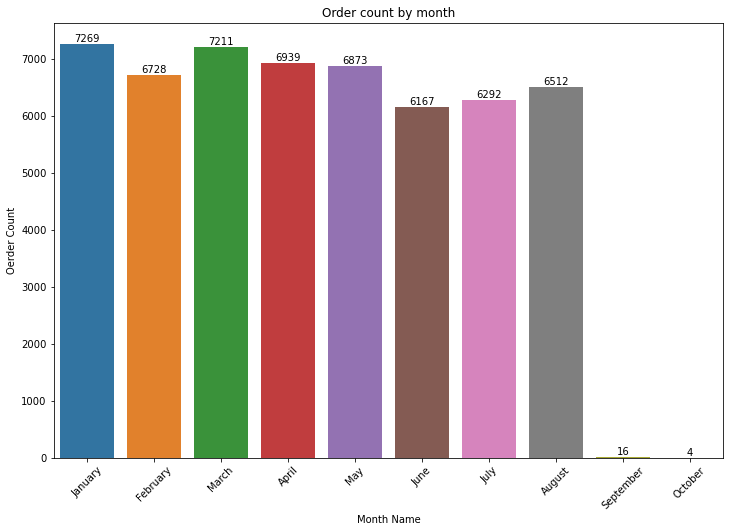

In [9]:
 query = """  select month(order_purchase_timestamp) 'MonthNumber',
 monthname(order_purchase_timestamp) 'MonthName',count(order_id) 'Orders_Count'
 from ecommerce.orders
 where year(order_purchase_timestamp) = '2018'
 GROUP BY 1,2
 ORDER BY 1;
"""

cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data)
df

# Adjust the figure size
plt.figure(figsize=(12, 8))

# Create the bar plot using Seaborn
ax = sns.barplot(x=df['MonthName'], y=df['Orders_Count'], data=df, order=df['MonthName'].unique())

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.xlabel('Month Name')
plt.ylabel('Oerder Count')
plt.title('Order count by month')

# Add bar labels
# for container in ax.containers:
#     ax.bar_label(container)
    
ax.bar_label(ax.containers[0])

# Show the plot
plt.show()

### 7: Find the average number of products per order, grouped by customer city.

In [10]:
 query = """  WITH ac AS 
( SELECT o.order_id,o.customer_id,COUNT(oi.order_id) AS order_count,GROUP_CONCAT(oi.order_id) AS order_ids
FROM ecommerce.orders o
LEFT JOIN ecommerce.order_items oi ON oi.order_id = o.order_id
GROUP BY o.order_id, o.customer_id
)
SELECT c.customer_city,round(avg(order_count),2)  'Average_order' FROM ac
LEFT JOIN ecommerce.customers c ON c.customer_id = ac.customer_id
GROUP BY 1
ORDER BY 2 DESC;
"""

cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data)
df.head()


,customer_city,Average_order
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00


### 8. Calculate the percentage of total revenue contributed by each product category.

In [11]:
 query = """  select p.product_category,count(oi.order_id) 'Total_order',round(sum(pe.payment_value),0) as 'Sales_Price',
round(round(round(sum(pe.payment_value),0)/(select sum(payment_value) from payments),2)*100,2) 'Sales_Price%'
 from ecommerce.products p 
left join ecommerce.order_items oi on oi.product_id = p.product_id
left join ecommerce.payments pe on pe.order_id = oi.order_id
GROUP BY 1 
ORDER BY 4 desc;
"""

cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data)
df.head()


,product_category,Total_order,Sales_Price,Sales_Price%
0,bed table bath,11823,1712554.0,11.0
1,computer accessories,8082,1585330.0,10.0
2,HEALTH BEAUTY,9975,1657373.0,10.0
3,sport leisure,8945,1392128.0,9.0
4,Watches present,6201,1429217.0,9.0


### 9. Identify the correlation between product price and the number of times a product has been purchased.

In [12]:
 query = """  select p.product_category,count(oi.order_id) 'Orders_count',round(avg(oi.price),2) 'Average_price',sum(oi.price) 'price'
 from ecommerce.products p
join ecommerce.order_items oi on oi.product_id = p.product_id
GROUP BY p.product_category;
"""

cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data)
df.head()

# Calculate the correlation matrix using Pearson method
correlation_matrix = df.corr(method='pearson')

print(correlation_matrix)


               Orders_count  Average_price     price
Orders_count       1.000000      -0.106315  0.950330
Average_price     -0.106315       1.000000  0.020548
price              0.950330       0.020548  1.000000


### 10. Calculate the total revenue generated by each seller, and rank them by revenue.

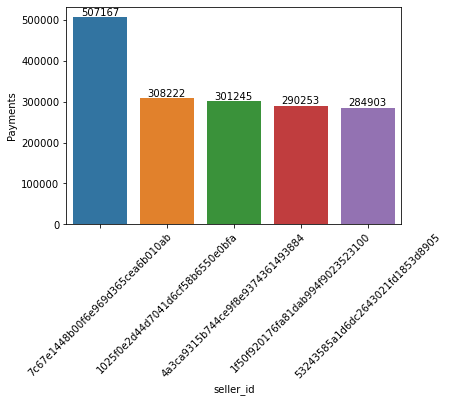

In [13]:
 query = """  with t as
(select s.seller_id,round(sum(p.payment_value),2) 'Payments' from ecommerce.sellers s
left join ecommerce.order_items oi on oi.seller_id = s.seller_id
left join ecommerce.payments p on p.order_id = oi.order_id
GROUP BY 1)
select t.seller_id,t.Payments,dense_rank() over(ORDER BY t.Payments desc) as 'Ranking'
from t;
"""

cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data)
df = df.head()

ax = sns.barplot(x = df['seller_id'],y = df['Payments'], data = df)
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])

plt.show()

### 11. Calculate the moving average of order values for each customer over their order history.

In [14]:
 query = """  select o.customer_id,o.order_purchase_timestamp,p.payment_value,
round(avg(p.payment_value) over(PARTITION BY o.customer_id ORDER BY o.order_purchase_timestamp 
ROWS BETWEEN 2 PRECEDING and CURRENT ROW),2) 'moving_average'
from ecommerce.payments p
left join ecommerce.orders o on o.order_id = p.order_id;
"""

cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data)
df.head()

,customer_id,order_purchase_timestamp,payment_value,moving_average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.74
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.41
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.42
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.35
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.01


### 12. Calculate the cumulative sales per month for each year.

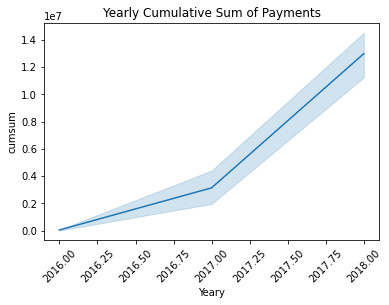

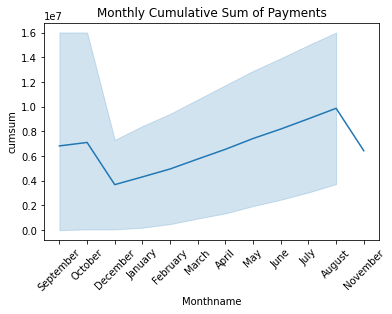

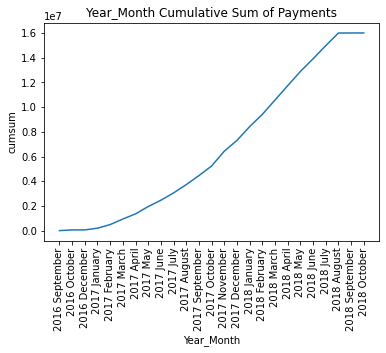

In [15]:
 query = """  
with a as
(select year(o.order_purchase_timestamp) 'Yeary',month(o.order_purchase_timestamp) 'Monthn'
,monthname(o.order_purchase_timestamp) 'Monthname',
round(sum(p.payment_value),2) 'Payments'
 from ecommerce.payments p
left join ecommerce.orders o on o.order_id = p.order_id
GROUP BY Yeary,Monthn,Monthname
ORDER BY Yeary,Monthn)
select a.Yeary,a.Monthname,concat(a.Yeary," ",a.Monthname) 'Year_Month',
a.Payments,Round(sum(a.Payments) over(ORDER BY a.Yeary,a.Monthn),2) 'cumsum'
 from a;

"""

cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data)
df.head()

# sns.lineplot(x = df['Yeary','Monthname'],y = df['cumsum'],data = df)
# plt.xticks(rotation=45)
# ax.bar_label(ax.containers[0])

# plt.show()

# Create the line plot for yearly cumulative sum
sns.lineplot(x='Yeary', y='cumsum', data=df)
plt.xticks(rotation=45)
plt.title('Yearly Cumulative Sum of Payments')
plt.show()

# Create the line plot for monthly cumulative sum
sns.lineplot(x='Monthname', y='cumsum', data=df)
plt.xticks(rotation=45)
plt.title('Monthly Cumulative Sum of Payments')
plt.show()


# Create the line plot for monthly cumulative sum
sns.lineplot(x='Year_Month', y='cumsum', data=df)
plt.xticks(rotation=90)
plt.title('Year_Month Cumulative Sum of Payments')
plt.show()


### 13. Calculate the year-over-year growth rate of total sales.

In [16]:
 query = """  
with a as
(select year(o.order_purchase_timestamp) 'Yeary',
round(sum(p.payment_value),2) 'Payments'
 from ecommerce.payments p
left join ecommerce.orders o on o.order_id = p.order_id
GROUP BY Yeary
ORDER BY Yeary)
select a.Yeary,a.Payments,lag(a.Payments,1,0) over(ORDER BY a.Yeary) 'Lag_payment',
round((a.Payments - lag(a.Payments,1,0) over(ORDER BY a.Yeary))/
(lag(a.Payments,1,0) over(ORDER BY a.Yeary))*100,2) as 'Growth_Rate'
from a;

"""

cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data)
df.head()

,Yeary,Payments,Lag_payment,Growth_Rate
0,2016,59362.34,0.00,NaN
1,2017,7249746.73,59362.34,12112.7
2,2018,8699763.05,7249746.73,20.0


### 14. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [17]:
 query = """  
with a as
(select c.customer_id,min(o.order_purchase_timestamp) 'First_order_date' from ecommerce.customers c
left join ecommerce.orders o on o.customer_id = c.customer_id
GROUP BY c.customer_id)
,b as
(select a.customer_id,count(distinct o.order_purchase_timestamp) nextorder from a
join ecommerce.orders o on o.customer_id = a.customer_id
and o.order_purchase_timestamp > a.First_order_date
and o.order_purchase_timestamp < 
date_add(First_order_date, interval  6 month)
GROUP BY a.customer_id)
select count(distinct a.customer_id)/count(distinct b.customer_id)*100  'Retention_Rate'
from a join b on b.customer_id = a.customer_id ;

"""

cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data)
df.head()

,Retention_Rate
0,None


### 15. Identify the top 3 customers who spent the most money in each year.

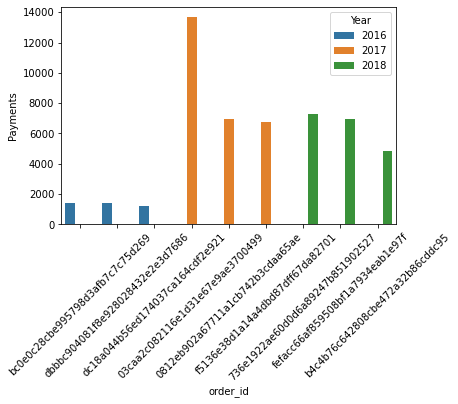

In [18]:
 query = """  
with a as
( select year(o.order_purchase_timestamp) 'Year',o.order_id,round(sum(p.payment_value),2) 'Payments'
 ,DENSE_RANK() OVER(PARTITION BY year(o.order_purchase_timestamp) ORDER BY sum(p.payment_value) desc) rn
 from ecommerce.orders o
 left join ecommerce.payments p on p.order_id = o.order_id
 GROUP BY 1,2)
 select * from a
 where a.rn <= 3
 ;
 

"""

cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data)
df.head()

sns.barplot(x = 'order_id', y= 'Payments', hue = 'Year', data = df )
plt.xticks(rotation = 45)
plt.show()